<a href="https://colab.research.google.com/github/aidantze/pesta-la-vista/blob/yolo_v8_dis/yolov8_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Starter Code**
- Imports
- Checking GPU availability
- Getting the Kaggle set and description of the download




In [2]:

!pip install -q ultralytics kagglehub pyyaml opencv-python efficientnet_pytorch torch torchvision
import torch
import numpy as np
import kagglehub
import pathlib
import yaml
import shutil
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
from pathlib import Path
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from efficientnet_pytorch import EfficientNet


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 81.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Check for T4 availability on Colab (DON'T CHANGE)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("No GPU detected. Go to Runtime -> Change runtime type ->  GPU")

CUDA available: True
GPU: NVIDIA A100-SXM4-80GB


In [4]:
# Getting the DATASET from kagglehub
# Kaggle Download via CLI API (see their website - DON'T CHANGE)
path = kagglehub.dataset_download("rupankarmajumdar/crop-pests-dataset")

# Saved the images to a local path to increase efficiency
local_path = pathlib.Path("/content/datasets/crop-pests")
local_path.parent.mkdir(parents=True, exist_ok=True)
shutil.copytree(path, local_path, dirs_exist_ok=True)

# YAML CONGIF (DON'T CHANGE)
data_yaml_path = local_path / "data.yaml"
data_cfg = {
    "path": str(local_path),
    "train": "train/images",
    "val":   "valid/images",
    "test":  "test/images",
    "nc": 12,
    "names":
     [
      "Ants",
      "Bees",
      "Beetles",
      "Catterpillars",     # NOTE: HAD TO CHANGE SPELLING BECAUSE DATASET IMAGES ARE SPELT LIKE THIS
      "Earthworms",
      "Earwigs",
      "Grasshoppers",
      "Moths",
      "Slugs",
      "Snails",
      "Wasps",
      "Weevils",
    ]
}

with open(data_yaml_path, "w") as f:
    yaml.safe_dump(data_cfg, f)


# CHECKS
# Count images in the train, valid, and test directories
num_train_images = len(list((local_path / "train" / "images").glob("*.jpg")))
num_val_images = len(list((local_path / "valid" / "images").glob("*.jpg")))
num_test_images = len(list((local_path / "test" / "images").glob("*.jpg")))

# Count labels in the train, valid, and test directories
num_train_labels = len(list((local_path / "train" / "labels").glob("*.txt")))
num_val_labels = len(list((local_path / "valid" / "labels").glob("*.txt")))
num_test_labels = len(list((local_path / "test" / "labels").glob("*.txt")))

print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_val_images}")
print(f"Number of test images: {num_test_images}")
print(f"Number of training labels: {num_train_labels}")
print(f"Number of validation labels: {num_val_labels}")
print(f"Number of test labels: {num_test_labels}")


Using Colab cache for faster access to the 'crop-pests-dataset' dataset.
Number of training images: 11502
Number of validation images: 1095
Number of test images: 546
Number of training labels: 11502
Number of validation labels: 1095
Number of test labels: 546


# **Our Evaluation Metrics**
- mAP@0.5 >= 0.5
- mAP@0.5:0.95 (elps you detect over/under-sized bounding boxes)
- Precision (false positive control)
- Recall (false negative control)
- F1 score
- Training and Testing times



In [5]:
def base_evaluation_metrics(val_results):
    # Extract YOLO summary metrics
    metrics = val_results.results_dict
    precision = metrics.get('metrics/precision(B)', 0)
    recall    = metrics.get('metrics/recall(B)', 0)
    mAP50     = metrics.get('metrics/mAP50(B)', 0)
    mAP50_95  = metrics.get('metrics/mAP50-95(B)', 0)

    # F1-score
    f1_score  = (2 * precision * recall) / (precision + recall) if (precision + recall) else 0


    # Display metrics
    print(f"\nMean Average Precision (mAP@0.5):        {mAP50:.4f}")
    print(f"Mean Average Precision (mAP@0.5:0.95):   {mAP50_95:.4f}")
    print(f"Precision: {precision:.4f}  |  Recall: {recall:.4f}  |  F1-score: {f1_score:.4f}")

In [6]:
def format_time(seconds):
    """Converts total seconds into minutes and format."""
    mins, secs = divmod(seconds, 60)
    return f"{int(mins):0d}m {secs:.2f}s"


# **Our Benchmark Model**

In [ ]:
# Training the Model (as per YOLOv8n website)
model = YOLO("yolov8n.pt")

start = time.time()
# See changes made to increase for Colab
train_res = model.train(
    data=str(data_yaml_path),
    epochs=10,
    imgsz=640,           # default image size
    batch=-1,            # auto-adjust batch size
    device=0,            # GPU
    project="pests_base",
    name="yolov8n_default",
    verbose=True
)

end = time.time()
train_time = end - start

# Validate the Model (as per YOLOv8n website)
start = time.time()
val_results = model.val(
    data=str(data_yaml_path),
    split="val",
    batch=16,
    device=0,
)

end = time.time()
val_time = end - start

base_evaluation_metrics(val_results)
print(f"Training Time (Total): {format_time(train_time)}")
print(f"Testing/Validation Time (Total): {format_time(val_time)}")

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/crop-pests/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_default3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, pers

# **Functions for EDA: Training and testing dataset**
Training
- how many images per class?

Validating
- how many images per class?

Testing
- how many images per class?
- how many were "no detection" in each class?
- how many were "misclassifies" in each class?




Total images in train set: 11502


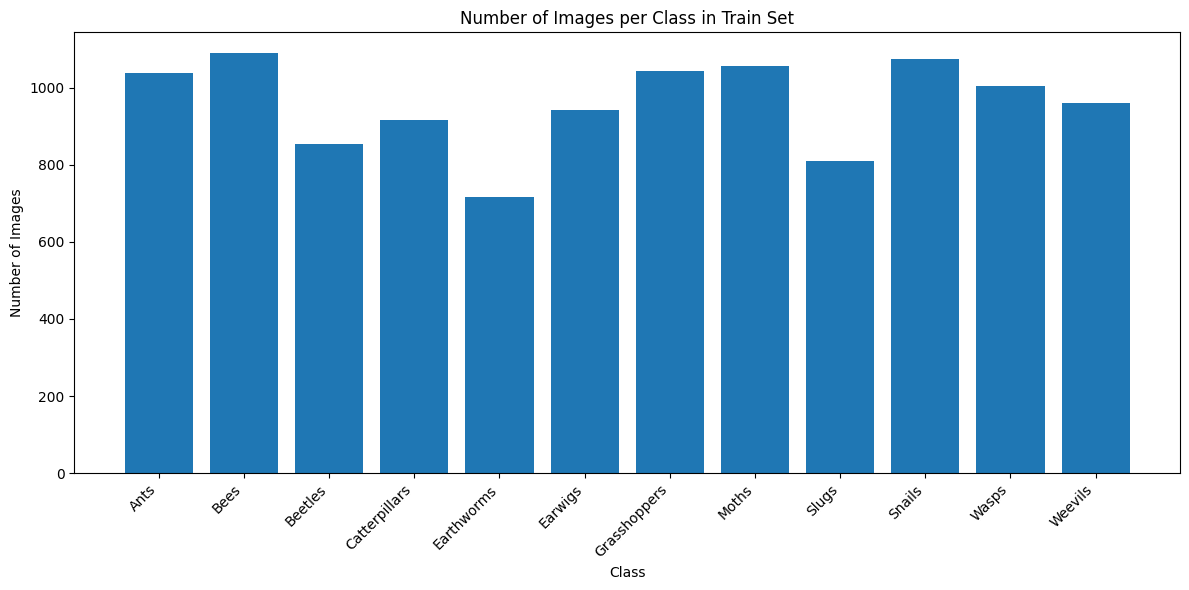


Total images in valid set: 1095


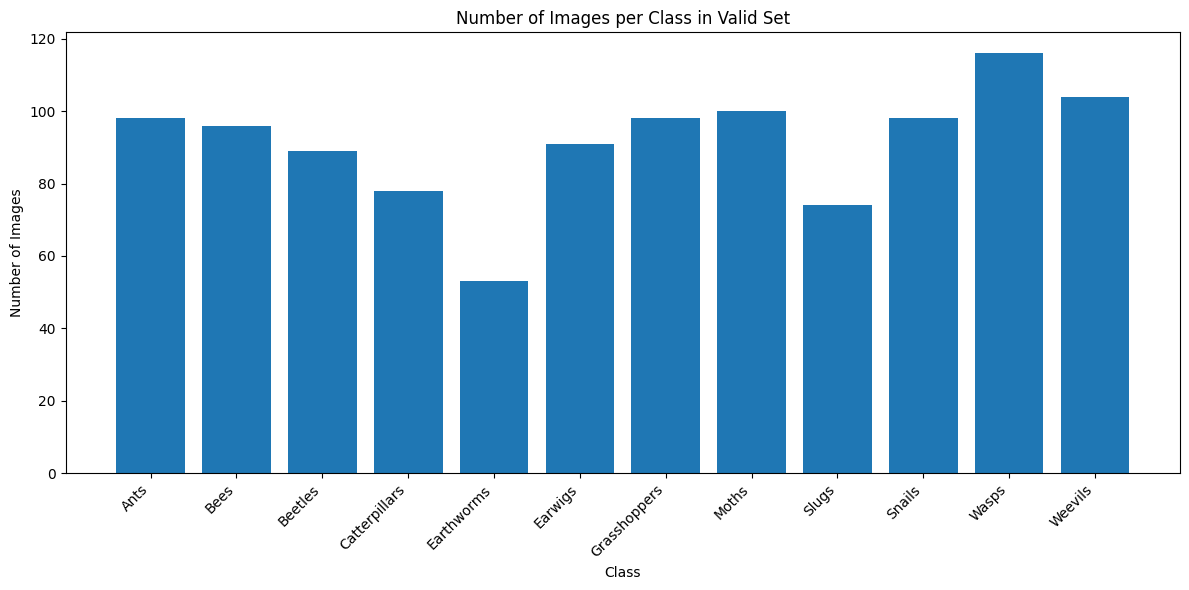


Total images in test set: 546


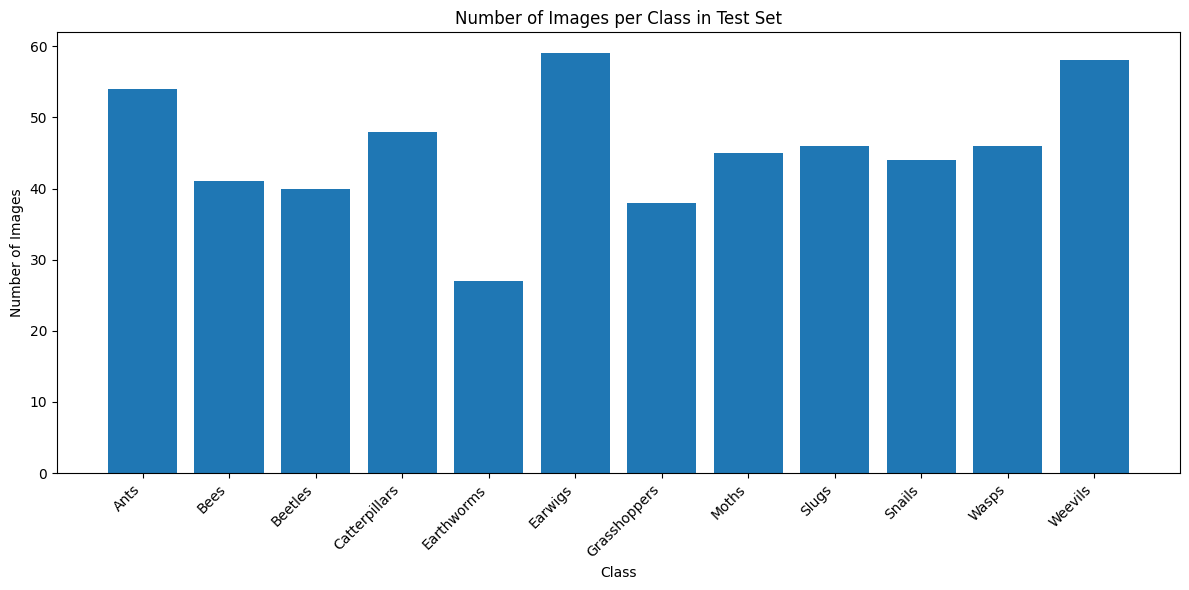

In [ ]:
# Dataset Analysis: Images per Class

root = Path("/content/datasets/crop-pests")

# Load class names
data_yaml_path = os.path.join(root, "data.yaml")
with open(data_yaml_path, "r") as f:
    names = yaml.safe_load(f)["names"]

# Create a lowercase version of the names list for easier comparison
names_new = [name.lower() for name in names]

# Init counters for images per class for each split
class_count = {split: {name: 0 for name in names} for split in ["train", "valid", "test"]}

# Iterate over train, valid, test and count images per class
for split in ["train", "valid", "test"]:
    image_dir = root / split / "images"
    # NOTE: Extracting the class name from the filenames instead of labels.
    for image_file in image_dir.glob("*.jpg"):
        filename = image_file.stem
        parts = filename.split('-')
        if len(parts) > 1:
            extracted_name = parts[0]
        else:
            parts = filename.split('_')
            extracted_name = parts[0]

        extracted_name_lower = extracted_name.lower()
        # accounting for any uppercase, plural variants
        if extracted_name_lower in names_new:
            original_name_index = names_new.index(extracted_name_lower)
            class_name = names[original_name_index]
            class_count[split][class_name] += 1
        elif extracted_name_lower + 's' in names_new:
             original_name_index = names_new.index(extracted_name_lower + 's')
             class_name = names[original_name_index]
             class_count[split][class_name] += 1
        else:
            print(f"Warning: Class name '{extracted_name}' extracted from filename '{filename}' not found in names.")


# Generate plots for image counts
for split, counts in class_count.items():
    # CHECK
    total_images = len(list((root / split / "images").glob("*.jpg")))
    print(f"\nTotal images in {split} set: {total_images}")

    plt.figure(figsize=(12, 6))
    class_names = list(counts.keys())
    image_counts = list(counts.values())
    plt.bar(class_names, image_counts)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(f"Number of Images per Class in {split.capitalize()} Set")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [ ]:

# # Analyze False Negatives, False Positives, and Misclassifications

# # Initialize dictionaries for counts
# false_negatives = {name: 0 for name in names}
# false_positives = {name: 0 for name in names}
# misclassified_counts = {name: 0 for name in names}


# # Count false negatives (unmatched ground truths)
# for image_path, actual_boxes in unmatched_ground_truths.items():
#     for actual_box in actual_boxes:
#         actual_class_name = names[actual_box['class_id']]
#         false_negatives[actual_class_name] += 1

# # Count false positives (predicted boxes without a match) and misclassifieds
# for res in test_res:
#     image_path = res.path
#     pred_boxes_raw = res.boxes.xywhn.tolist()
#     pred_classes_raw = res.boxes.cls.tolist()

#     predicted_data_for_image = []
#     for i in range(len(pred_boxes_raw)):
#          predicted_data_for_image.append({
#             'center_x': pred_boxes_raw[i][0],
#             'center_y': pred_boxes_raw[i][1],
#             'width': pred_boxes_raw[i][2],
#             'height': pred_boxes_raw[i][3],
#             'class_id': int(pred_classes_raw[i]),
#         })

#     # Get the matched predicted boxes for the current image
#     matched_pred_boxes_for_image = [match['predicted'] for match in matched_predictions.get(image_path, [])]

#     for pred_box in predicted_data_for_image:
#         is_false_positive = True
#         for matched_pred_box in matched_pred_boxes_for_image:
#             # Compare dictionaries for equality (excluding confidence for this check)
#             if pred_box['center_x'] == matched_pred_box['center_x'] and \
#                pred_box['center_y'] == matched_pred_box['center_y'] and \
#                pred_box['width'] == matched_pred_box['width'] and \
#                pred_box['height'] == matched_pred_box['height'] and \
#                pred_box['class_id'] == matched_pred_box['class_id']:
#                 is_false_positive = False
#                 break

#         if is_false_positive:
#             pred_class_name = names[pred_box['class_id']]
#             false_positives[pred_class_name] += 1


# # Count misclassifieds from matched predictions
# for image_path, matches in matched_predictions.items():
#     for match in matches:
#         predicted_box = match['predicted']
#         ground_truth_box = match['ground_truth']
#         if predicted_box['class_id'] != ground_truth_box['class_id']:
#             actual_class_name = names[ground_truth_box['class_id']]
#             misclassified_counts[actual_class_name] += 1


# # Generate bar charts for these counts
# plt.figure(figsize=(12, 6))
# classes = list(false_negatives.keys())
# counts = list(false_negatives.values())
# plt.bar(classes, counts)
# plt.xlabel("Class")
# plt.ylabel("Number of False Negatives")
# plt.title("Number of False Negatives per Class (Missed Detections)")
# plt.xticks(rotation=45, ha="right")
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(12, 6))
# classes = list(false_positives.keys())
# counts = list(false_positives.values())
# plt.bar(classes, counts)
# plt.xlabel("Class")
# plt.ylabel("Number of False Positives")
# plt.title("Number of False Positives per Class (Wrong Detections)")
# plt.xticks(rotation=45, ha="right")
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(12, 6))
# classes = list(misclassified_counts.keys())
# counts = list(misclassified_counts.values())
# plt.bar(classes, counts)
# plt.xlabel("Class")
# plt.ylabel("Number of Misclassified Objects")
# plt.title("Number of Misclassified Objects per Class")
# plt.xticks(rotation=45, ha="right")
# plt.tight_layout()
# plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# interest_names = names
# class_ids_of_interest = [names.index(c) for c in interest_names]
# # Initialize lists to store true and predicted labels for the confusion matrix
# y_true = []
# y_pred = []

# # Process matched predictions
# for image_path, matches in matched_predictions.items():
#     for match in matches:
#         predicted_box = match['predicted']
#         actual_box = match['ground_truth']

#         # Only include if both actual box and predicted classes are in the classes of interest
#         if actual_box['class_id'] in class_ids_of_interest and predicted_box['class_id'] in class_ids_of_interest:
#             y_true.append(actual_box['class_id'])
#             y_pred.append(predicted_box['class_id'])
#         elif actual_box['class_id'] in class_ids_of_interest and predicted_box['class_id'] not in class_ids_of_interest:
#              # NOTE: If ground truth is of interest but prediction is not, we are considering  it a misclassification.
#              # A more complex approach would involve an 'other' category in the matrix, where we can't explicitely state it.
#              pass
#         elif actual_box['class_id'] not in class_ids_of_interest and predicted_box['class_id'] in class_ids_of_interest:
#              # NOTE: If prediction is of interest but ground truth is not, consider it a false positive for the predicted class.
#              pass


# # Handle false negatives for the classes of interest
# for image_path, true_boxes in unmatched_ground_truths.items():
#     for true_box in true_boxes:
#         if true_box['class_id'] in class_ids_of_interest:
#             # This is a false negative for this class
#             y_true.append(true_box['class_id'])
#             # NOTE: Using len(names) as a placeholder for 'no detection'
#             y_pred.append(len(names))


# # Create a mapping from original class ID to new class ID
# original_to_new_class_id = {original_id: new_id for new_id, original_id in enumerate(class_ids_of_interest)}
# original_to_new_class_id[len(names)] = len(interest_names)
# y_true_mapped = [original_to_new_class_id[label] for label in y_true]
# y_pred_mapped = [original_to_new_class_id[label] for label in y_pred]


# # Define labels for the confusion matrix plot
# confusion_matrix_labels = interest_names + ["No Detection"]

# # Generate the confusion matrix
# cm = confusion_matrix(y_true_mapped, y_pred_mapped, labels=range(len(confusion_matrix_labels)))

# # Plot the confusion matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=confusion_matrix_labels,
#             yticklabels=confusion_matrix_labels)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix for Selected Classes')
# plt.show()

In [ ]:
# # Analyze Confidence for Matched Predictions (True Positives and Misclassifications)
# correct_confidences = {name: [] for name in names}
# misclassified_confidences = {name: [] for name in names}

# for image_path, matches in matched_predictions.items():
#     # Getting each prediction's confidence and its correponding actual class
#     for match in matches:
#         predicted_box = match['predicted']
#         actual_box = match['ground_truth']
#         confidence = predicted_box['confidence']
#         true_class_name = names[actual_box['class_id']]
#         # Accounting for the cases: they are same and they are different
#         if predicted_box['class_id'] == actual_box['class_id']:
#             correct_confidences[true_class_name].append(confidence)
#         else:
#             misclassified_confidences[true_class_name].append(confidence)


# # Analyze Confidence for False Positives
# false_positive_confidences = {name: [] for name in names}

# for res in test_res:
#     image_path = res.path
#     pred_boxes_raw = res.boxes.xywhn.tolist()
#     pred_classes_raw = res.boxes.cls.tolist()
#     pred_confidences_raw = res.boxes.conf.tolist()

#     predicted_data_for_image = []
#     for i in range(len(pred_boxes_raw)):
#          predicted_data_for_image.append({
#             'center_x': pred_boxes_raw[i][0],
#             'center_y': pred_boxes_raw[i][1],
#             'width': pred_boxes_raw[i][2],
#             'height': pred_boxes_raw[i][3],
#             'class_id': int(pred_classes_raw[i]),
#             'confidence': pred_confidences_raw[i]
#         })

#     # Get the matched predicted boxes for the current image
#     matched_pred_boxes_for_image = [match['predicted'] for match in matched_predictions.get(image_path, [])]

#     for pred_box in predicted_data_for_image:
#         is_false_positive = True
#         for matched_pred_box in matched_pred_boxes_for_image:
#             # Compare dictionaries for equality
#             if pred_box == matched_pred_box:
#                 is_false_positive = False
#                 break

#         if is_false_positive:
#             pred_class_name = names[pred_box['class_id']]
#             false_positive_confidences[pred_class_name].append(pred_box['confidence'])


# # Calculate Average Confidences
# avg_correct_confidences = {name: np.mean(confidences) if confidences else 0 for name, confidences in correct_confidences.items()}
# avg_misclassified_confidences = {name: np.mean(confidences) if confidences else 0 for name, confidences in misclassified_confidences.items()}
# avg_false_positive_confidences = {name: np.mean(confidences) if confidences else 0 for name, confidences in false_positive_confidences.items()}

# # Visualise Confidence Distributions
# classes = list(names)
# bar_width = 0.25
# r1 = np.arange(len(classes))
# r2 = [x + bar_width for x in r1]
# r3 = [x + bar_width for x in r2]

# plt.figure(figsize=(14, 7))
# plt.bar(r1, [avg_correct_confidences[c] for c in classes], color='skyblue', width=bar_width, edgecolor='grey', label='Correctly Classified')
# plt.bar(r2, [avg_misclassified_confidences[c] for c in classes], color='salmon', width=bar_width, edgecolor='grey', label='Misclassified')
# plt.bar(r3, [avg_false_positive_confidences[c] for c in classes], color='lightgreen', width=bar_width, edgecolor='grey', label='False Positive')
# plt.xlabel('Class', fontweight='bold')
# plt.ylabel('Average Confidence', fontweight='bold')
# plt.title('Average Confidence per Class for Different Detection Outcomes', fontweight='bold')
# plt.xticks([r + bar_width for r in range(len(classes))], classes, rotation=45, ha='right')
# plt.legend()
# plt.tight_layout()
# plt.show()


# # Summarise Findings
# print("\nAverage Confidence per Class:\n")

# for class_name in classes:
#     print(f"{class_name}:")
#     print(f"  Correctly Classified: {avg_correct_confidences[class_name]:.4f}")
#     print(f"  Misclassified:        {avg_misclassified_confidences[class_name]:.4f}")
#     print(f"  False Positive:       {avg_false_positive_confidences[class_name]:.4f}")

# **Initial Limitations**
- **mAP@0.5 = 0.61 and mAP@0.5:0.95 = 0.34:** This indicates a large gap , meaning localisation quality across high IoUs is an issue.
- **Precision > Recall:** It seems that we are missing objects more than mislabelling them.
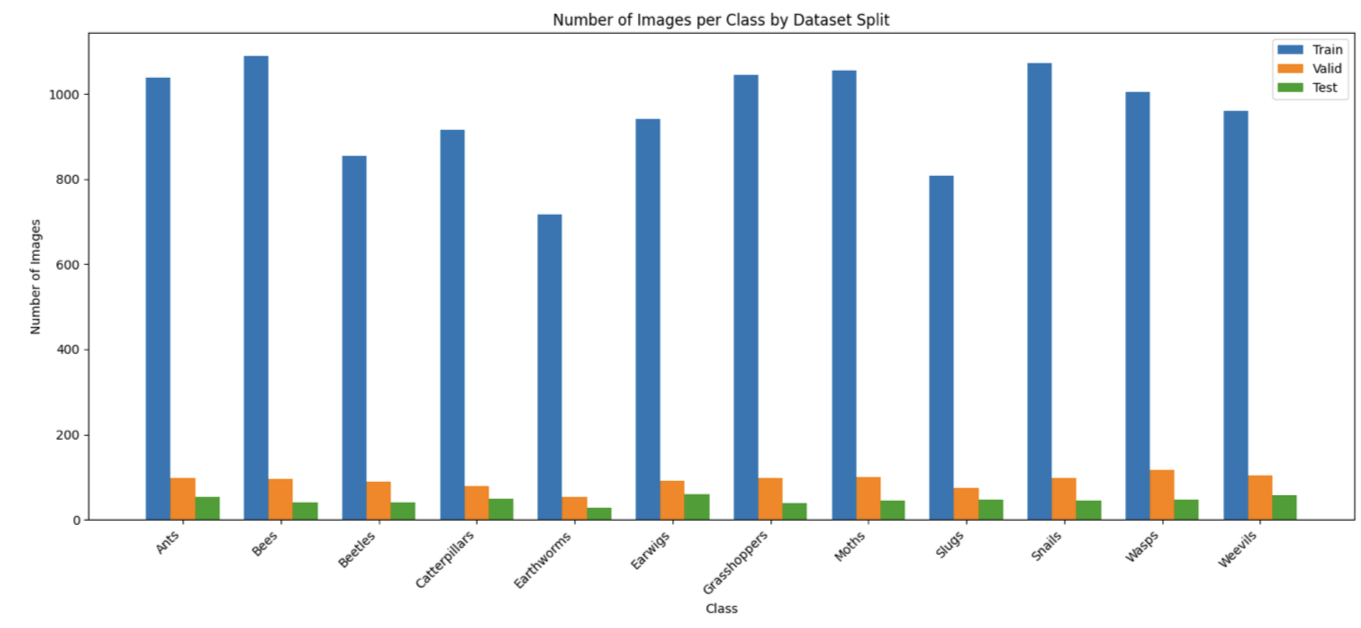


- There is a class data imbalance in training and validating sets.

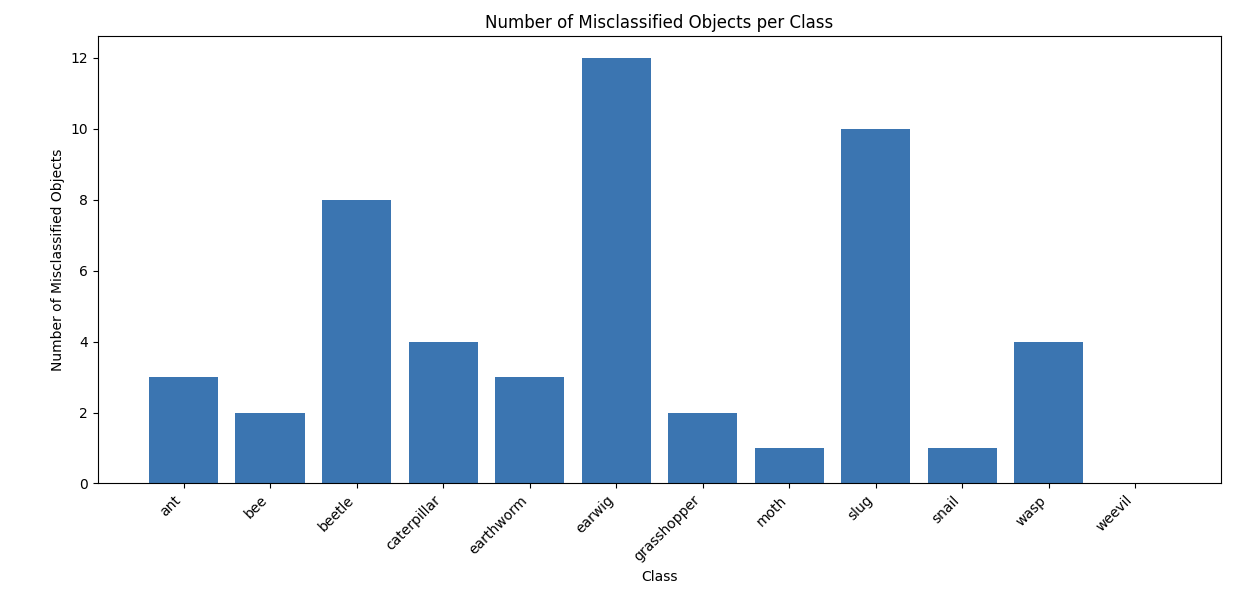

- The high misclassification rates for earwig, slug, and beetle likely stem from their similar colour and shape features, making them visually hard to distinguish. Additionally, mosaic and resizing augmentations (which our base model has) may blur fine details such as antennae and shells that are crucial for accurate classification.

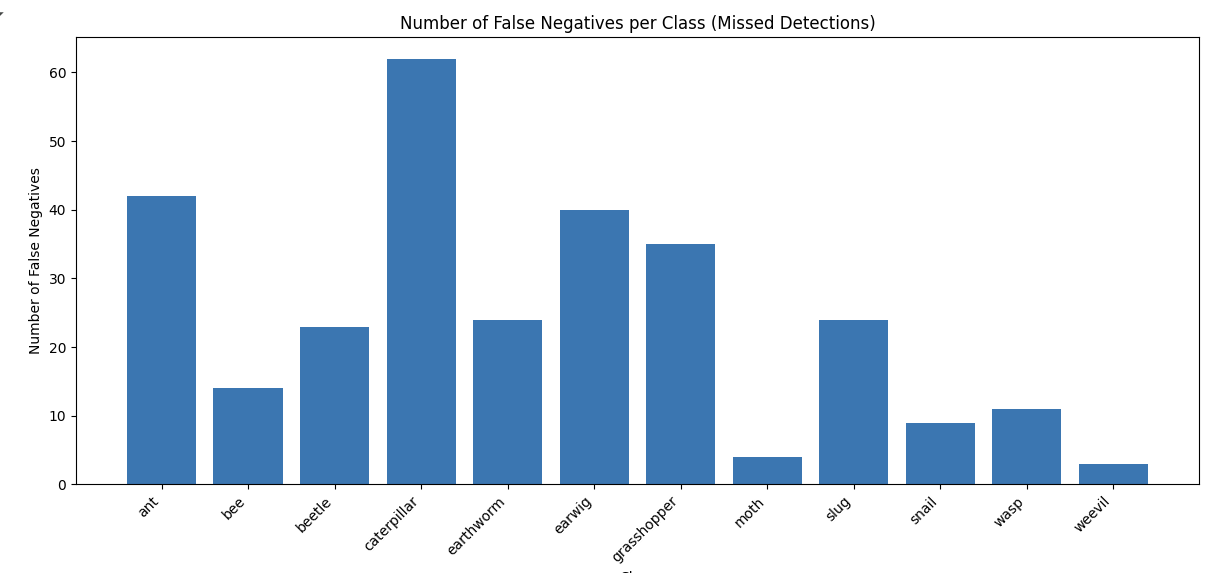

- The high number of missed detections is likely due to small or camouflaged insects like caterpillars, ants, and earwigs blending into their surroundings, making them difficult to detect. Additionally, dataset imbalance and low input resolution reduce the model’s ability to learn distinct features, while a high confidence threshold may be filtering out valid detections during post-processing.
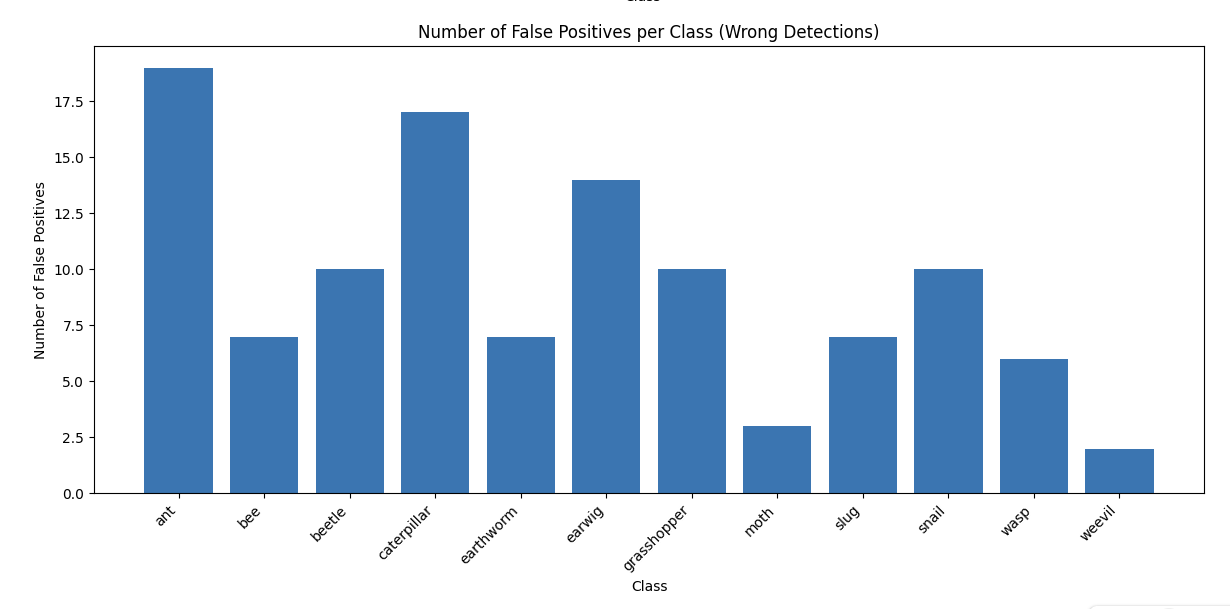
- Similarly, high false positives are likely caused by visual similarity between insects (e.g., ants, caterpillars, earwigs), background clutter that mimics insect features. It could also be due to class imbalancs especially towards ants.

# Our focus:
- Precision is higher than recall: confidence calibration and filtering
- Data Imbalance and feature bias
- Small Object and Localisation
- Looking and focusing more into the ants, caterpillars, earwigs, beetles and slugs classes

# Noise and Filter/Blur CHECK
--------------------------------------------------------
- Gaussian Noise
- Salt & Pepper
- Gaussian Blur

In [ ]:
# Noise and filter constants
APPLY_CORRUPTION = True
CORRUPT_TYPE = 'gaussian_blur'   # one of: 'gaussian_noise', 'salt_pepper_noise', 'gaussian_blur'
CORRUPT_STRENGTH = 0.2

In [ ]:
import cv2

# Noise and filter/blur analysis
def apply_corruption_to_folder(source_img_dir, destination_img_dir, corruption_type, strength=0.01):
    """
    Copies images from source to destination and applies a specified corruption.

    Args:
        source_img_dir (pathlib.Path): Directory containing original images.
        destination_img_dir (pathlib.Path): Target directory for corrupted images.
        corruption_type (str): 'gaussian_noise', 'salt_pepper_noise', 'gaussian_blur'.
        strength (float/int): Magnitude of the corruption.
    """
    # Determine corresponding label directories
    source_lbl_dir = source_img_dir.parent / "labels"
    destination_lbl_dir = destination_img_dir.parent / "labels"

    # Remove existing destination directories if they exist
    if destination_img_dir.exists():
        shutil.rmtree(destination_img_dir)
    if destination_lbl_dir.exists():
        shutil.rmtree(destination_lbl_dir)

    # Copy images and labels
    shutil.copytree(source_img_dir, destination_img_dir)
    if source_lbl_dir.exists():
        shutil.copytree(source_lbl_dir, destination_lbl_dir)


    if corruption_type == 'gaussian_noise':
        # Mean=0, standard deviation=strength * 255
        sigma = int(strength * 255)
        print(f"\nApplying {corruption_type} (Sigma: {sigma}) to images in {destination_img_dir.name}...")

        for img_file in destination_img_dir.glob('*.jpg'): # Adjust extension if needed
            img = cv2.imread(str(img_file))
            if img is None:
                continue

            img_f = img.astype(np.float32)
            noise = np.random.normal(0, sigma, img.shape).astype(np.float32)
            corrupted_img = img_f + noise
            corrupted_img = np.clip(corrupted_img, 0, 255).astype(np.uint8)

            # Save the corrupted image, overwriting the copy
            cv2.imwrite(str(img_file), corrupted_img)

    elif corruption_type == 'salt_pepper_noise':
        ratio = strength # Ratio of pixels to corrupt
        print(f"\nApplying {corruption_type} (Ratio: {ratio}) to images in {destination_img_dir.name}...")

        for img_file in destination_img_dir.glob('*.jpg'): # Adjust extension if needed
            img = cv2.imread(str(img_file))
            if img is None:
                continue

            corrupted_img = img.copy()
            h, w, c = img.shape
            num_pixels = int(ratio * h * w)

            # Salt (white)
            ys = np.random.randint(0, h, num_pixels)
            xs = np.random.randint(0, w, num_pixels)
            corrupted_img[ys, xs, :] = 255

            # Pepper (black)
            ys = np.random.randint(0, h, num_pixels)
            xs = np.random.randint(0, w, num_pixels)
            corrupted_img[ys, xs, :] = 0

            cv2.imwrite(str(img_file), corrupted_img)

    elif corruption_type == 'gaussian_blur':
        ksize = int(strength * 20)  # scale to 1–20
        ksize = max(1, ksize)
        if ksize % 2 == 0:
            ksize += 1

        print(f"\nApplying {corruption_type} (ksize: {ksize}) to images in {destination_img_dir.name}...")

        for img_file in destination_img_dir.glob('*.jpg'):
            img = cv2.imread(str(img_file))
            if img is None:
                continue

            corrupted_img = cv2.GaussianBlur(img, (ksize, ksize), 0)
            cv2.imwrite(str(img_file), corrupted_img)


if (APPLY_CORRUPTION):
  # Create a new validation directory for the corrupted test set
  original_val_path = local_path / "valid" / "images"
  corrupt_val_path = local_path / "valid_noisy" / "images"

  # Apply corruption to the copied test set
  # We use 'valid' here since YOLOv8 validation defaults to the 'val' split name.
  apply_corruption_to_folder(
      original_val_path,
      corrupt_val_path,
      CORRUPT_TYPE,
      CORRUPT_STRENGTH
  )

  # Update the YAML to point to the corrupted validation set for the experiment
  data_cfg_corrupted = data_cfg.copy()
  data_cfg_corrupted['val'] = "valid_noisy/images"
  data_yaml_path_corrupted = local_path / "data_corrupted.yaml"

  with open(data_yaml_path_corrupted, "w") as f:
      yaml.safe_dump(data_cfg_corrupted, f)
  print("Wrote corrupted config:", data_yaml_path_corrupted)


Applying gaussian_blur (ksize: 5) to images in images...
Wrote corrupted config: /content/datasets/crop-pests/data_corrupted.yaml


In [ ]:
model = YOLO("yolov8n.pt")

# Train the mode
# comment/uncomment lines with device=0 for Colab and device="cpu" for personal
# only one of the above should be commented out
start = time.time()
train_res = model.train(
    data=str(data_yaml_path_corrupted if APPLY_CORRUPTION else data_yaml_path),
    epochs=10,
    imgsz=640,
    batch=-1,
    device=0,
    cache=True,          # cache dataset in RAM/Disk for speed
    amp=True,            # mixed precision
    project="pests_fast",
    name="yolov8n_colab",
    plots=False
)

end = time.time()
train_time = end - start

# Validate the Model (as per YOLOv8n website)
start = time.time()
val_results = model.val(
    data=str(data_yaml_path_corrupted if APPLY_CORRUPTION else data_yaml_path),
    split="val", # Ensure this points to the corrupted set if APPLY_CORRUPTION is True
    batch=16,
    iou=0.5,
    device=0,
    workers=2
)

end = time.time()
val_time = end - start


base_evaluation_metrics(val_results)
print(f"Training Time (Total): {format_time(train_time)}")
print(f"Testing/Validation Time (Total): {format_time(val_time)}")


Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/crop-pests/data_corrupted.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_colab5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10

# Resolution and Mosaic testing

------------------------------------------

- image_size_list = [64, 128, 256, 512, 640]
- mosaic_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]



In [17]:
# Load the hypertuned YOLOv8n model

def call_model_1(epoch_size=10, image_size=640, mosaic_amount=1.0):
  model= YOLO("yolov8n.pt")
  start = time.time()
  train_res = model.train(
      data=str(data_yaml_path),
      batch=-1,
      device=0,
      amp=True,

      epochs=epoch_size,
      imgsz=image_size,
      mosaic=mosaic_amount,
      cache=True,


      project="pests_fast",
      name="yolov8n_wiou_like",
  )


  end = time.time()
  train_time = end - start

  start = time.time()
  # Validate the Model
  val_results = model.val(
      data=str(data_yaml_path),
      split="val",
      batch=16,
      device=0,
      iou = 0.5,
      workers=2
  )

  end = time.time()
  val_time = end - start

  base_evaluation_metrics(val_results)
  print(f"Training Time (Total): {format_time(train_time)}")
  print(f"Testing/Validation Time (Total): {format_time(val_time)}")


In [18]:
image_size_list = [64, 128, 256, 512, 640]

# DUE TO RAM ISSUES, CALLED SEPARATELY.
# Running on contsant 20 epochs for time
# Setting baseline
# call_model_1(image_size=image_size_list[0])
# call_model_1(image_size=image_size_list[1])
# call_model_1(image_size=image_size_list[2])
# call_model_1(image_size=image_size_list[3])
call_model_1(image_size=image_size_list[4])



Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/crop-pests/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_wiou_like, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, pers

KeyboardInterrupt: 

**call_model_1(image_size=image_size_list[0])**
- Mean Average Precision (mAP@0.5):        0.5145
Mean Average Precision (mAP@0.5:0.95):   0.2505
Precision: 0.5544  |  Recall: 0.4849  |  F1-score: 0.5173
Training Time (Total): 9m 34.87s
Testing/Validation Time (Total): 0m 8.76s

**call_model_1(image_size=image_size_list[1])**
Mean Average Precision (mAP@0.5):        0.6577
Mean Average Precision (mAP@0.5:0.95):   0.3768
Precision: 0.7324  |  Recall: 0.5873  |  F1-score: 0.6519
Training Time (Total): 9m 53.36s
Testing/Validation Time (Total): 0m 9.02s

**call_model_1(image_size=image_size_list[2])**
Mean Average Precision (mAP@0.5):        0.7382
Mean Average Precision (mAP@0.5:0.95):   0.4342
Precision: 0.8095  |  Recall: 0.6682  |  F1-score: 0.7321
Training Time (Total): 9m 51.80s
Testing/Validation Time (Total): 0m 9.22s

**call_model_1(image_size=image_size_list[3])**
Mean Average Precision (mAP@0.5):        0.7359
Mean Average Precision (mAP@0.5:0.95):   0.4249
Precision: 0.8050  |  Recall: 0.6800  |  F1-score: 0.7372
Training Time (Total): 5m 9.23s
Testing/Validation Time (Total): 0m 9.47s

**call_model_1(image_size=image_size_list[4])**
Mean Average Precision (mAP@0.5):        0.7248
Mean Average Precision (mAP@0.5:0.95):   0.4099
Precision: 0.7818  |  Recall: 0.6710  |  F1-score: 0.7222
Training Time (Total): 6m 43.25s
Testing/Validation Time (Total): 0m 10.78s

In [19]:
mosaic_list = [0.2, 0.4, 0.6, 0.8, 0.0]

# DUE TO RAM ISSUES, CALLED SEPARATELY.
# Running on contsant 20 epochs for time
# Setting baseline
# call_model_1(mosaic_amount=mosaic_list[0])
# call_model_1(mosaic_amount=mosaic_list[1])
# call_model_1(mosaic_amount=mosaic_list[2])
#call_model_1(mosaic_amount=mosaic_list[3])
call_model_1(mosaic_amount=mosaic_list[4])





Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/crop-pests/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.0, multi_scale=False, name=yolov8n_wiou_like2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, per

**call_model_1(mosaic_amount=mosaic_list[0])**
Mean Average Precision (mAP@0.5):        0.7339
Mean Average Precision (mAP@0.5:0.95):   0.4147
Precision: 0.8058  |  Recall: 0.6660  |  F1-score: 0.7293
Training Time (Total): 6m 35.93s
Testing/Validation Time (Total): 0m 10.92s

**call_model_1(mosaic_amount=mosaic_list[1])**
Mean Average Precision (mAP@0.5):        0.7248
Mean Average Precision (mAP@0.5:0.95):   0.4099
Precision: 0.7818  |  Recall: 0.6710  |  F1-score: 0.7222
Training Time (Total): 6m 35.80s
Testing/Validation Time (Total): 0m 11.17s

**call_model_1(mosaic_amount=mosaic_list[2])**
Mean Average Precision (mAP@0.5):        0.7339
Mean Average Precision (mAP@0.5:0.95):   0.4147
Precision: 0.8058  |  Recall: 0.6660  |  F1-score: 0.7293
Training Time (Total): 6m 34.23s
Testing/Validation Time (Total): 0m 10.76s

**call_model_1(mosaic_amount=mosaic_list[3])**
Mean Average Precision (mAP@0.5):        0.7248
Mean Average Precision (mAP@0.5:0.95):   0.4099
Precision: 0.7818  |  Recall: 0.6710  |  F1-score: 0.7222
Training Time (Total): 6m 35.59s
Testing/Validation Time (Total): 0m 11.05s

**call_model_1(mosaic_amount=mosaic_list[4])**



####

# Minority Class Duplication and Augmentation
--------------------------------------------------------
- rotating by 180 degress
- adding salt and pepper noise
- Mosaic:1
- Resolution: 512

In [9]:
# Ensure local_path and names are defined
local_path = Path("/content/datasets/crop-pests")
data_yaml = yaml.safe_load(open(local_path / "data.yaml"))
names = data_yaml["names"]

minority_classes = ["Slugs", "Earthworms", "Beetles", "Catterpillars", "Earwigs"]

# Hyperparameters
MAX_DUPLICATES = 1000
SP_AMOUNT = 0.05
SP_SALT_VS_PEPPER = 0.5


def add_salt_and_pepper_noise(img, amount=0.05, salt_vs_pepper=0.5):
    noisy = img.copy()
    h, w = noisy.shape[:2]
    num_pixels = h * w
    num_salt = int(amount * num_pixels * salt_vs_pepper)
    num_pepper = int(amount * num_pixels * (1 - salt_vs_pepper))

    # Salt (white) noise
    ys = np.random.randint(0, h, num_salt)
    xs = np.random.randint(0, w, num_salt)
    noisy[ys, xs] = 255

    # Pepper (black) noise
    ys = np.random.randint(0, h, num_pepper)
    xs = np.random.randint(0, w, num_pepper)
    noisy[ys, xs] = 0

    return noisy


# Get the class IDs for minority classes
minority_class_ids = [names.index(c) for c in minority_classes if c in names]

duplicated_count = 0  # make sure this exists even if no minority classes

if not minority_class_ids:
    print("No valid minority classes specified from the dataset names.")
else:
    print(f"Minority classes for duplication: {minority_classes}")

    train_images_dir = local_path / "train" / "images"
    train_labels_dir = local_path / "train" / "labels"

    # Create directories for duplicated images and labels
    duplicated_images_dir = local_path / "train" / "images_duplicated"
    duplicated_labels_dir = local_path / "train" / "labels_duplicated"

    # Clean up previous runs if any
    if duplicated_images_dir.exists():
        shutil.rmtree(duplicated_images_dir)
    if duplicated_labels_dir.exists():
        shutil.rmtree(duplicated_labels_dir)

    duplicated_images_dir.mkdir(parents=True, exist_ok=True)
    duplicated_labels_dir.mkdir(parents=True, exist_ok=True)

    processed_images_count = 0

    for label_file in train_labels_dir.glob("*.txt"):
        # Stop once we hit 200 duplicates
        if duplicated_count >= MAX_DUPLICATES:
            break

        image_file = train_images_dir / f"{label_file.stem}.jpg"
        if not image_file.exists():
            continue

        has_minority_class = False
        try:
            with open(label_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if parts:
                        class_id = int(parts[0])
                        if class_id in minority_class_ids:
                            has_minority_class = True
                            break  # Found a minority class
        except Exception as e:
            print(f"Error reading label file {label_file}: {e}")
            continue  # Skip this file if there's an error

        if has_minority_class:
            processed_images_count += 1

            new_image_name = f"{image_file.stem}_dup{1}{image_file.suffix}"
            new_label_name = f"{label_file.stem}_dup{1}{label_file.suffix}"

            new_image_path = duplicated_images_dir / new_image_name
            new_label_path = duplicated_labels_dir / new_label_name

            try:
                # Read original image
                img = cv2.imread(str(image_file))
                if img is None:
                    print(f"Warning: Could not read image {image_file} for augmentation.")
                    continue

                # 1) Add salt-and-pepper noise
                noisy_img = add_salt_and_pepper_noise(
                    img,
                    amount=SP_AMOUNT,
                    salt_vs_pepper=SP_SALT_VS_PEPPER
                )

                # 2) Rotate 180 degrees
                rotated_img = cv2.rotate(noisy_img, cv2.ROTATE_180)

                # Save augmented image
                cv2.imwrite(str(new_image_path), rotated_img)

                # Duplicate label file (no change to coords)
                shutil.copy2(str(label_file), str(new_label_path))

                duplicated_count += 1

            except Exception as e:
                print(f"Error duplicating files for {image_file}: {e}")

print(f"Total Duplicates: {duplicated_count}")

Minority classes for duplication: ['Slugs', 'Earthworms', 'Beetles', 'Catterpillars', 'Earwigs']
Total Duplicates: 1000


In [10]:
# Generate Training File List Including Duplicated Images (No Copying)

import os
from pathlib import Path

# Assume 'local_path' is defined from previous cells

original_train_images_dir = local_path / "train" / "images"
# This is for duplicates
duplicated_images_dir = local_path / "train" / "images_duplicated"

train_file_list_path = local_path / "train_images_list.txt"

all_train_image_paths = []

# Collect original image paths
if original_train_images_dir.exists():
    print(f"Collecting images from: {original_train_images_dir}")
    all_train_image_paths.extend([str(p.resolve()) for p in original_train_images_dir.glob("*.jpg")])
else:
    print(f"Warning: Original training images directory not found at {original_train_images_dir}")


# Collect duplicated image paths
if duplicated_images_dir.exists():
    print(f"Collecting images from: {duplicated_images_dir}")
    all_train_image_paths.extend([str(p.resolve()) for p in duplicated_images_dir.glob("*.jpg")])
else:
    print(f"Warning: Duplicated images directory not found at {duplicated_images_dir}")


# Write the file list to a text file
with open(train_file_list_path, "w") as f:
    for img_path in all_train_image_paths:
        f.write(f"{img_path}\n")

print(f"\nGenerated training image file list at: {train_file_list_path}")
print(f"Total images included in the file list: {len(all_train_image_paths)}")


Generated training image file list at: /content/datasets/crop-pests/train_images_list.txt
Total images included in the file list: 12502


In [11]:
# Update data.yaml to Use the Training File List

data_yaml_path = local_path / "data.yaml"

# Load the existing data.yaml content
if data_yaml_path.exists():
    with open(data_yaml_path, "r") as f:
        data_cfg = yaml.safe_load(f)
else:
    print(f"Warning: data.yaml not found at {data_yaml_path}. Creating a new one.")
    data_cfg = {
        "path": str(local_path), # Keep the root path for val/test
        "val":   "valid/images",
        "test":  "test/images",
        "nc": 12,
        "names":
         [
          "Ants",
          "Bees",
          "Beetles",
          "Catterpillars",
          "Earthworms",
          "Earwigs",
          "Grasshoppers",
          "Moths",
          "Slugs",
          "Snails",
          "Wasps",
          "Weevils",
        ]
    }

data_cfg["train"] = str(train_file_list_path.resolve())


# Write the updated data.yaml file
with open(data_yaml_path, "w") as f:
    yaml.safe_dump(data_cfg, f)


print(yaml.safe_dump(data_cfg))


names:
- Ants
- Bees
- Beetles
- Catterpillars
- Earthworms
- Earwigs
- Grasshoppers
- Moths
- Slugs
- Snails
- Wasps
- Weevils
nc: 12
path: /content/datasets/crop-pests
test: test/images
train: /content/datasets/crop-pests/train_images_list.txt
val: valid/images



In [9]:
model = YOLO("yolov8n.pt")
start = time.time()
train_res = model.train(
    # Use the data.yaml file which now points to the training image file list
    data=str(local_path/"data.yaml"),
    epochs=10,
    imgsz=512,
    mosaic=1.0,
    batch=-1,
    device=0,
    project="pests_fast",
    name="yolov8n_colab",
    verbose=True
)

end = time.time()
train_time = end - start

# Validate the Model (as per YOLOv8n website)
start = time.time()
val_results = model.val(
    data=str(local_path/"data.yaml"),
    split="val",
    batch=16,
    iou=0.5,
    device=0,
    workers=2
)

end = time.time()
val_time = end - start

base_evaluation_metrics(val_results)
print(f"Training Time (Total): {format_time(train_time)}")
print(f"Testing/Validation Time (Total): {format_time(val_time)}")

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/crop-pests/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_colab6, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspe

In [10]:
base_evaluation_metrics(val_results)
print(f"Training Time (Total): {format_time(train_time)}")
print(f"Testing/Validation Time (Total): {format_time(val_time)}")


Mean Average Precision (mAP@0.5):        0.7411
Mean Average Precision (mAP@0.5:0.95):   0.4088
Precision: 0.7706  |  Recall: 0.7064  |  F1-score: 0.7371
Training Time (Total): 5m 43.07s
Testing/Validation Time (Total): 0m 8.95s


Mean Average Precision (mAP@0.5):        0.7411
Mean Average Precision (mAP@0.5:0.95):   0.4088
Precision: 0.7706  |  Recall: 0.7064  |  F1-score: 0.7371
Training Time (Total): 5m 43.07s
Testing/Validation Time (Total): 0m 8.95s

# Epoch Optimising
------------------------------------------



In [13]:
model = YOLO("yolov8n.pt")
start = time.time()
train_res = model.train(
    # Use the data.yaml file which now points to the training image file list
    data=str(local_path/"data.yaml"),
    epochs=50,
    imgsz=512,
    mosaic=1.0,
    batch=-1,
    device=0,
    project="pests_fast",
    name="yolov8n_colab",
    verbose=True
)

end = time.time()
train_time = end - start


# Validate the Model (as per YOLOv8n website)
start = time.time()
val_results = model.val(
    data=str(local_path/"data.yaml"),
    split="val",
    batch=16,
    iou=0.5,
    device=0,
    workers=2
)

end = time.time()
val_time = end - start

base_evaluation_metrics(val_results)
print(f"Training Time (Total): {format_time(train_time)}")
print(f"Testing/Validation Time (Total): {format_time(val_time)}")

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/crop-pests/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_colab7, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspe

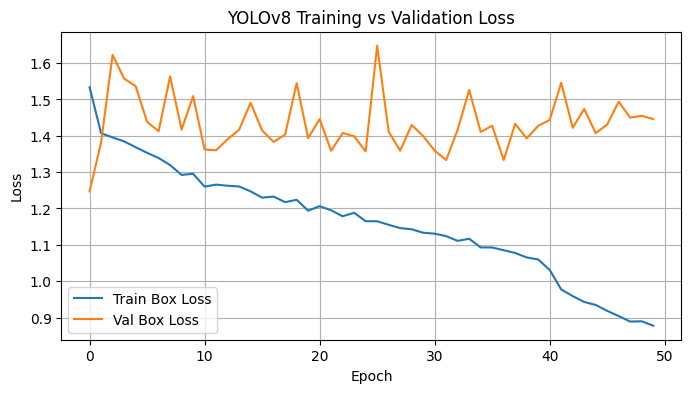

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Dynamically construct the path to results.csv using the save_dir from the training run
results_csv_path = Path(train_res.save_dir) / "results.csv"

# Check if the file exists before attempting to read it
if results_csv_path.exists():
    df = pd.read_csv(results_csv_path)

    plt.figure(figsize=(8,4))
    plt.plot(df["train/box_loss"], label="Train Box Loss")
    plt.plot(df["val/box_loss"], label="Val Box Loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"YOLOv8 Training vs Validation Loss")
    plt.grid(True)
    plt.show()
else:
    print(f"Error: results.csv not found at {results_csv_path}")

# Two-Layer Yolo
--------------------------------------------------------
- Stage 1: 15 epoch, default mosaic, 256x256
- Stage 2: 10 epoch, no mosaic, 512x512

Addition of augmented duplicates for minotiry classes
Adding in two-layer Yolo artitecture

In [15]:
base_p = pathlib.Path("/content") if os.path.isdir("/content") else pathlib.Path.cwd()
cfg_p = local_path/"data.yaml"
runs_p = base_p / "yolo_runs"
runs_p.mkdir(parents=True, exist_ok=True)

# Aims to have strong aug, smaller resolution. Thus, learn robust features faster
yolo_1 = YOLO("yolov8n.pt")
start = time.time()

train_res_1 = yolo_1.train(
    data=str(cfg_p),
    epochs=15,
    imgsz=256,
    batch=8,
    device=0,
    workers=2,
    project=str(runs_p),
    name="cp_s1_mosaic",
    verbose=False,
    mosaic=1.0

)
#**********************************************

end = time.time()
train_time = end - start

# Validate the Model (as per YOLOv8n website)
start = time.time()
val_results = yolo_1.val(
    data=str(data_yaml_path),
    split="val",
    batch=16,
    device=0,
)

end = time.time()
val_time = end - start

base_evaluation_metrics(val_results)
print(f"Training Time (Total): {format_time(train_time)}")
print(f"Testing/Validation Time (Total): {format_time(val_time)}")

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/crop-pests/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=cp_s1_mosaic3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspect

Mean Average Precision (mAP@0.5):        0.7205
Mean Average Precision (mAP@0.5:0.95):   0.4485
Precision: 0.7877  |  Recall: 0.6702  |  F1-score: 0.7242
Training Time (Total): 26m 28.21s
Testing/Validation Time (Total): 0m 8.47s

In [16]:

# Aims to fine-tune from best.pt with realistic images
best_1 = runs_p / "cp_s1_mosaic" / "weights" / "best.pt"

yolo_2 = YOLO(str(best_1))

start = time.time()
train_res_2 = yolo_2.train(
    data=str(local_path/"data.yaml"),
    epochs=10,
    imgsz=512,
    batch=8,
    device=0,
    workers=2,
    project=str(runs_p),
    name="cp_s2_nomosaic",
    verbose=False,
    mosaic=0.0    # Changed
)

end = time.time()
train_time = end - start

# Validate the Model (as per YOLOv8n website)
start = time.time()
val_results = yolo_2.val(
    data=str(data_yaml_path),
    split="val",
    batch=16,
    device=0,
)

end = time.time()
val_time = end - start

base_evaluation_metrics(val_results)
print(f"Training Time (Total): {format_time(train_time)}")
print(f"Testing/Validation Time (Total): {format_time(val_time)}")

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/crop-pests/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/yolo_runs/cp_s1_mosaic/weights/best.pt, momentum=0.937, mosaic=0.0, multi_scale=False, name=cp_s2_nomosaic2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, ov


Mean Average Precision (mAP@0.5):        0.7326
Mean Average Precision (mAP@0.5:0.95):   0.4429
Precision: 0.7949  |  Recall: 0.6838  |  F1-score: 0.7352
Training Time (Total): 18m 48.33s
Testing/Validation Time (Total): 0m 9.33s

# Final Testing
- Default Model
- Epoch 10 Optimised
- Epoch 15 Optimised
- Two-Layer Approach

In [8]:
# DEFAULT MODEL
# Training the Model (as per YOLOv8n website)
model = YOLO("yolov8n.pt")

start = time.time()
# See changes made to increase for Colab
train_res = model.train(
    data=str(data_yaml_path),
    epochs=10,
    imgsz=640,           # default image size
    batch=-1,            # auto-adjust batch size
    device=0,            # GPU
    project="pests_base",
    name="yolov8n_default",
    verbose=True
)

end = time.time()
train_time = end - start

# Validate the Model (as per YOLOv8n website)
start = time.time()
val_results = model.val(
    data=str(data_yaml_path),
    split="test",
    batch=16,
    device=0,
)

end = time.time()
val_time = end - start

base_evaluation_metrics(val_results)
print(f"Training Time (Total): {format_time(train_time)}")
print(f"Testing/Validation Time (Total): {format_time(val_time)}")

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/crop-pests/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_default, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, persp

In [ ]:
# NOTE: 1. Run The Duplicaition and Augmentation Image creation FIRST

In [12]:
# OPTIMISED 10 EPOCH


model = YOLO("yolov8n.pt")
start = time.time()
train_res = model.train(
    # Use the data.yaml file which now points to the training image file list
    data=str(local_path/"data.yaml"),
    epochs=10,
    imgsz=512,
    mosaic=1.0,
    batch=-1,
    device=0,
    project="pests_fast",
    name="yolov8n_colab",
    verbose=True
)

end = time.time()
train_time = end - start

# Validate the Model (as per YOLOv8n website)
start = time.time()
val_results = model.val(
    data=str(local_path/"data.yaml"),
    split="test",
    batch=16,
    iou=0.5,
    device=0,
    workers=2
)

end = time.time()
val_time = end - start

base_evaluation_metrics(val_results)
print(f"Training Time (Total): {format_time(train_time)}")
print(f"Testing/Validation Time (Total): {format_time(val_time)}")

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/crop-pests/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_colab2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspe

In [14]:
 # OPTIMISED 15 EPOCH


model = YOLO("yolov8n.pt")
start = time.time()
train_res = model.train(
    # Use the data.yaml file which now points to the training image file list
    data=str(local_path/"data.yaml"),
    epochs=15,
    imgsz=512,
    mosaic=1.0,
    batch=-1,
    device=0,
    project="pests_fast",
    name="yolov8n_colab",
    verbose=True
)

end = time.time()
train_time = end - start

# Validate the Model (as per YOLOv8n website)
start = time.time()
val_results = model.val(
    data=str(local_path/"data.yaml"),
    split="test",
    batch=16,
    iou=0.5,
    device=0,
    workers=2
)

end = time.time()
val_time = end - start

base_evaluation_metrics(val_results)
print(f"Training Time (Total): {format_time(train_time)}")
print(f"Testing/Validation Time (Total): {format_time(val_time)}")

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/crop-pests/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_colab4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspe

In [15]:
base_p = pathlib.Path("/content") if os.path.isdir("/content") else pathlib.Path.cwd()
cfg_p = local_path/"data.yaml"
runs_p = base_p / "yolo_runs"
runs_p.mkdir(parents=True, exist_ok=True)

# Aims to have strong aug, smaller resolution. Thus, learn robust features faster
yolo_1 = YOLO("yolov8n.pt")
start = time.time()

train_res_1 = yolo_1.train(
    data=str(cfg_p),
    epochs=15,
    imgsz=256,
    batch=8,
    device=0,
    workers=2,
    project=str(runs_p),
    name="cp_s1_mosaic",
    verbose=False,
    mosaic=1.0

)
#**********************************************

end = time.time()
train_time = end - start

# Validate the Model (as per YOLOv8n website)
start = time.time()
val_results = yolo_1.val(
    data=str(data_yaml_path),
    split="test",
    batch=16,
    device=0,
)

end = time.time()
val_time = end - start

base_evaluation_metrics(val_results)
print(f"Training Time (Total): {format_time(train_time)}")
print(f"Testing/Validation Time (Total): {format_time(val_time)}")


# Aims to fine-tune from best.pt with realistic images
best_1 = runs_p / "cp_s1_mosaic" / "weights" / "best.pt"

yolo_2 = YOLO(str(best_1))

start = time.time()
train_res_2 = yolo_2.train(
    data=str(local_path/"data.yaml"),
    epochs=10,
    imgsz=512,
    batch=8,
    device=0,
    workers=2,
    project=str(runs_p),
    name="cp_s2_nomosaic",
    verbose=False,
    mosaic=0.0    # Changed
)

end = time.time()
train_time = end - start

# Validate the Model (as per YOLOv8n website)
start = time.time()
val_results = yolo_2.val(
    data=str(data_yaml_path),
    split="test",
    batch=16,
    device=0,
)

end = time.time()
val_time = end - start

base_evaluation_metrics(val_results)
print(f"Training Time (Total): {format_time(train_time)}")
print(f"Testing/Validation Time (Total): {format_time(val_time)}")


Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/crop-pests/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=cp_s1_mosaic, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspecti